In [158]:
from pathlib import Path
import os
import yaml
import pandas as pd
import numpy as np

from utils.helpers import flatten_dict

import seaborn as sns
import matplotlib.pyplot as plt
import string

from utils.helpers import flatten_dict, set_rcParams



In [229]:
def load_hierarchical_experiment_results(exp_dir, split="test"):

    # TODO keep path prefixes (e.g. eyepacs/eyepacs_gender/c2st/hash/version_x)

    # TODO save the following variables
    # - date of experiment
    # - subset attribute

    config_dicts = []
    result_dfs = []

    exclude_strings = ["task", "archive", "debug"]

    # get all experiments from subfolders
    for path in Path(exp_dir).rglob(f"{split}_consistency_analysis.csv"):
        path_parts = path.parts

        if not set(path_parts).isdisjoint(exclude_strings):
            continue

        version = path_parts[-2]
        exp_hash = path_parts[-3]
        method = path_parts[-4]

        config_file = os.path.join('/' + '/'.join(path_parts[1:-2]), "config.yaml")

        # open config
        with open(config_file) as fhandle:
            params = yaml.safe_load(fhandle)

        params = flatten_dict(params, sep="_")
        result = pd.read_csv(path)
        
        params["exp_hash"] = exp_hash
        result["exp_hash"] = exp_hash
        result["version"] = version
        result["method"] = method
        result["path"] = str(path.parent)
        
        config_dicts.append(params)
        result_dfs.append(result)
        
    configs = pd.DataFrame(config_dicts)
    configs = configs.set_index("exp_hash")
        
    results = pd.concat(result_dfs)
    results = results.set_index(["exp_hash", "sample_size"], drop=False)
    
    # keep latest version only!
    configs = configs[~configs.index.duplicated(keep="last")]
    results = results[~results.index.duplicated(keep="last")]

    
    df = configs.join(results)        
        
    return df




In [230]:
exp_dir = "/home/lkoch/mnt/slurm_work/exp_lightning"

df = load_hierarchical_experiment_results(exp_dir)


KeyError: "None of ['exp_hash'] are in the columns"

In [182]:

columns_of_interest = ['dataset_ds_data_augmentation',
                        'path', 'dataset_ds_basic_preproc_img_size', 'dataset_ds_p_dataset', 'dataset_ds_p_subset_params_center', 
                        'dataset_ds_q_dataset', 'dataset_ds_q_subset_params_center', 
                        'domain_classifier_model_arch', 
                        'domain_classifier_model_optim_config_learning_rate', 'mmd_model_feature_extractor', 'mmd_model_img_size', 'mmd_model_loss_lambda', 
                        'mmd_model_loss_type', 'task_classifier_model_arch', 'task_classifier_model_optim_config_learning_rate', 
                        'dataset_ds_p_subset_params_diagnoses_comorbidities', 'dataset_ds_q_subset_params_diagnoses_comorbidities', 'dataset_ds_p_subset_params_patient_ethnicity', 'dataset_ds_q_subset_params_patient_ethnicity', 'dataset_ds_p_subset_params_patient_gender', 'dataset_ds_q_subset_params_patient_gender', 'dataset_ds_p_subset_params_session_image_quality', 'dataset_ds_q_subset_params_session_image_quality', 'dataset_ds_data_frac', 'dataset_ds_p_subset_params_p_erase', 'dataset_ds_p_subset_params_scale_erase', 'dataset_ds_q_subset_params_p_erase', 'dataset_ds_q_subset_params_scale_erase', 'sample_size', 'power', 'type_1err', 'method', 'power_stderr', 'type_1err_stderr', 'exp_hash', 'version'] 
    

df = df[columns_of_interest]



df.to_csv('all_results.csv')


# MNIST results

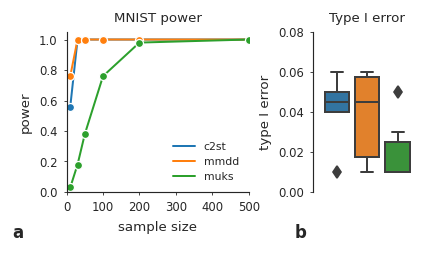

In [321]:
df = pd.read_csv('all_results.csv')

mnist = df[df["dataset_ds_p_dataset"] == "mnist"]
mnist = mnist[mnist["domain_classifier_model_arch"]!= "resnet50"]
mnist.shape

set_rcParams()

sns.set_style("ticks")

num_plots = 2
fig, ax = plt.subplots(1,num_plots, figsize=(3.4,2), facecolor='white', gridspec_kw={'width_ratios': [2, 1]},
                       layout="constrained",
                       )


idx=0
sns.lineplot(data=mnist, x='sample_size', y='power', hue='method', ax=ax[0], marker='o')
ax[idx].set_title("MNIST power")
ax[idx].set_xlim([0, 500])
ax[idx].set_ylim([0, 1.05])
ax[idx].grid(False)
# ax[idx].set(xscale="log")

ax[idx].set_xlabel("sample size")


handles, labels = ax[idx].get_legend_handles_labels()
ax[idx].legend(handles=handles, labels=labels)
ax[idx].get_legend().get_frame().set_linewidth(0.0)


sns.despine()

idx=1

# mnist.boxplot(column=['type_1err'], by='method', ax=ax[idx])

bp = sns.boxplot(data=mnist, x="method", y="type_1err", ax=ax[idx])

bp.set(xticklabels=[])
bp.set(xlabel=None)
# bp.axhline(0.05, linestyle='--', color='k')

ax[idx].set_title("Type I error")
ax[idx].grid(False)
# ax[idx].plot()
ax[idx].spines['top'].set_visible(False)
ax[idx].spines['right'].set_visible(False)
ax[idx].set_ylim([0, 0.08])

ax[idx].set_ylabel("type I error")

ax[idx].spines['bottom'].set_visible(False)
ax[idx].set_xticks([])
# ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")
ax[idx].spines['left'].set_position(('outward', 5))
# plt.figure()

txtkwargs = dict(size=10, weight='bold', va='top', ha='left')

for idx in range(num_plots):
    ax[idx].text(-0.3, -0.2, string.ascii_lowercase[idx], transform=ax[idx].transAxes, **txtkwargs)

# plt.tight_layout()


fig.savefig('mnist_results.pdf')

# Camelyon results

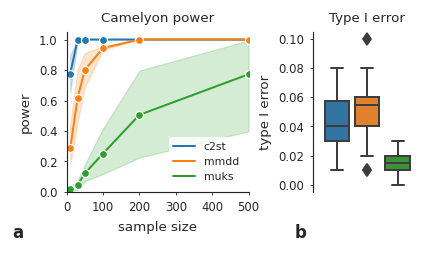

In [320]:
df = pd.read_csv('all_results.csv')

camelyon = df[df["dataset_ds_p_dataset"] == "camelyon"]
# mnist = mnist[mnist["domain_classifier_model_arch"]!= "resnet50"]
# mnist.shape
mnist = camelyon

set_rcParams()

sns.set_style("ticks")

num_plots = 2
fig, ax = plt.subplots(1,num_plots, figsize=(3.4,2), facecolor='white', gridspec_kw={'width_ratios': [2, 1]},
                       layout="constrained",
                       )


idx=0
sns.lineplot(data=mnist, x='sample_size', y='power', hue='method', marker='o', ax=ax[0])
ax[idx].set_title("Camelyon power")
ax[idx].set_xlim([0, 500])
ax[idx].set_ylim([0, 1.05])
ax[idx].grid(False)
# ax[idx].set(xscale="log")

ax[idx].set_xlabel("sample size")


handles, labels = ax[idx].get_legend_handles_labels()
ax[idx].legend(handles=handles, labels=labels)
ax[idx].get_legend().get_frame().set_linewidth(0.0)


sns.despine()

idx=1

# mnist.boxplot(column=['type_1err'], by='method', ax=ax[idx])

bp = sns.boxplot(data=mnist, x="method", y="type_1err", ax=ax[idx])

bp.set(xticklabels=[])
bp.set(xlabel=None)
# bp.axhline(0.05, linestyle='--', color='k')

ax[idx].set_title("Type I error")
ax[idx].grid(False)
# ax[idx].plot()
ax[idx].spines['top'].set_visible(False)
ax[idx].spines['right'].set_visible(False)
# ax[idx].set_ylim([0, 0.08])

ax[idx].set_ylabel("type I error")

ax[idx].spines['bottom'].set_visible(False)
ax[idx].set_xticks([])
# ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")
ax[idx].spines['left'].set_position(('outward', 5))
# plt.figure()

txtkwargs = dict(size=10, weight='bold', va='top', ha='left')

for idx in range(num_plots):
    ax[idx].text(-0.3, -0.2, string.ascii_lowercase[idx], transform=ax[idx].transAxes, **txtkwargs)

# plt.tight_layout()


fig.savefig('camelyon_results.pdf')

# print(camelyon.shape)

# Eyepacs main results


(18, 38)
(126, 38)
['/home/lkoch/mnt/slurm_work/exp_lightning/eyepacs/eyepacs_comorb/muks/2b027d3107ce2b40ef40cb8db848f625/version_1', '/home/lkoch/mnt/slurm_work/exp_lightning/eyepacs/eyepacs_comorb/muks/2b027d3107ce2b40ef40cb8db848f625/version_1', '/home/lkoch/mnt/slurm_work/exp_lightning/eyepacs/eyepacs_comorb/muks/2b027d3107ce2b40ef40cb8db848f625/version_1', '/home/lkoch/mnt/slurm_work/exp_lightning/eyepacs/eyepacs_comorb/muks/2b027d3107ce2b40ef40cb8db848f625/version_1', '/home/lkoch/mnt/slurm_work/exp_lightning/eyepacs/eyepacs_comorb/muks/2b027d3107ce2b40ef40cb8db848f625/version_1', '/home/lkoch/mnt/slurm_work/exp_lightning/eyepacs/eyepacs_comorb/muks/2b027d3107ce2b40ef40cb8db848f625/version_1']


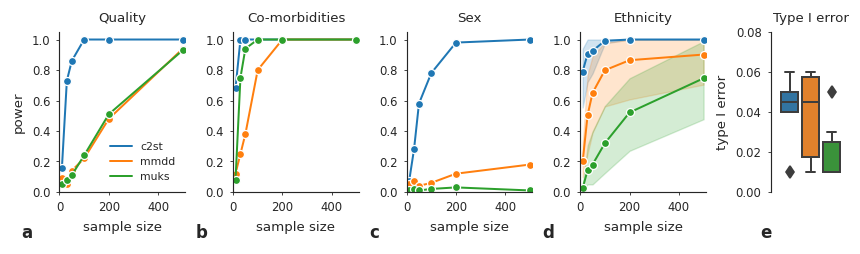

In [345]:
df = pd.read_csv('all_results.csv')

eyepacs = df[df["dataset_ds_p_dataset"] == "eyepacs"]


# eyepacs = eyepacs[eyepacs["dataset_ds_data_frac"]==1]

eyepacs = eyepacs[eyepacs['path'].str.contains("task") == False]
eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_data_frac") == False]
eyepacs = eyepacs[eyepacs['path'].str.contains("eyepacs_quality_mmd_ablation") == False]


drop_rows = (eyepacs['method'] == "c2st") & (eyepacs["dataset_ds_basic_preproc_img_size"] == 96)

eyepacs = eyepacs[drop_rows == False]

# print(drop_rows)
# c2st = c2st[c2st["dataset_ds_basic_preproc_img_size"] == 512]

x = eyepacs
# x = df.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
# x["dataset_ds_q_subset_params_session_image_quality"]
x.shape

quality = x.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
ethnicity = x.dropna(subset=["dataset_ds_p_subset_params_patient_ethnicity"])
sex = x.dropna(subset=["dataset_ds_p_subset_params_patient_gender"])
comorbids = x.dropna(subset=["dataset_ds_q_subset_params_diagnoses_comorbidities"])

print(quality.shape)
print(ethnicity.shape)




set_rcParams()

sns.set_style("ticks")

num_plots = 5
fig, ax = plt.subplots(1,num_plots, figsize=(7,2), facecolor='white', gridspec_kw={'width_ratios': [2, 2, 2, 2, 1]},
                       layout="constrained",
                       )



idx=0
sns.lineplot(data=quality, x='sample_size', y='power', hue='method', ax=ax[idx], marker='o')
ax[idx].set_title("Quality")
ax[idx].set_xlim([0, 510])
ax[idx].set_ylim([0, 1.05])
ax[idx].grid(False)
# ax[idx].set(xscale="log")

ax[idx].set_xlabel("sample size")


handles, labels = ax[idx].get_legend_handles_labels()
ax[idx].legend(handles=handles, labels=labels)
ax[idx].get_legend().get_frame().set_linewidth(0.0)


sns.despine()

idx=1
sns.lineplot(data=comorbids, x='sample_size', y='power', hue='method', ax=ax[idx], marker='o')
ax[idx].set_title("Co-morbidities")
ax[idx].set_xlim([0, 510])
ax[idx].set_ylim([0, 1.05])
ax[idx].grid(False)
# ax[idx].set(xscale="log")

ax[idx].set_xlabel("sample size")
ax[idx].set_ylabel(None)


# handles, labels = ax[idx].get_legend_handles_labels()
# ax[idx].legend(handles=handles, labels=labels)
# ax[idx].get_legend().get_frame().set_linewidth(0.0)
ax[idx].get_legend().remove()


sns.despine()

idx=2
sns.lineplot(data=sex, x='sample_size', y='power', hue='method', ax=ax[idx], marker='o')
ax[idx].set_title("Sex")
ax[idx].set_xlim([0, 510])
ax[idx].set_ylim([0, 1.05])
ax[idx].grid(False)
# ax[idx].set(xscale="log")

ax[idx].set_xlabel("sample size")
ax[idx].set_ylabel(None)


# handles, labels = ax[idx].get_legend_handles_labels()
# ax[idx].legend(handles=handles, labels=labels)
# ax[idx].get_legend().get_frame().set_linewidth(0.0)
ax[idx].get_legend().remove()


sns.despine()

idx=3
sns.lineplot(data=ethnicity, x='sample_size', y='power', hue='method', ax=ax[idx], marker='o')
ax[idx].set_title("Ethnicity")
ax[idx].set_xlim([0, 510])
ax[idx].set_ylim([0, 1.05])
ax[idx].grid(False)
# ax[idx].set(xscale="log")

ax[idx].set_xlabel("sample size")
ax[idx].set_ylabel(None)


# handles, labels = ax[idx].get_legend_handles_labels()
# ax[idx].legend(handles=handles, labels=labels)
# ax[idx].get_legend().get_frame().set_linewidth(0.0)
ax[idx].get_legend().remove()


sns.despine()

idx=4

# mnist.boxplot(column=['type_1err'], by='method', ax=ax[idx])

bp = sns.boxplot(data=mnist, x="method", y="type_1err", ax=ax[idx])

bp.set(xticklabels=[])
bp.set(xlabel=None)
# bp.axhline(0.05, linestyle='--', color='k')

ax[idx].set_title("Type I error")
ax[idx].grid(False)
# ax[idx].plot()
ax[idx].spines['top'].set_visible(False)
ax[idx].spines['right'].set_visible(False)
ax[idx].set_ylim([0, 0.08])

ax[idx].set_ylabel("type I error")

ax[idx].spines['bottom'].set_visible(False)
ax[idx].set_xticks([])
# ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")
ax[idx].spines['left'].set_position(('outward', 5))
# plt.figure()

txtkwargs = dict(size=10, weight='bold', va='top', ha='left')

for idx in range(num_plots):
    ax[idx].text(-0.3, -0.2, string.ascii_lowercase[idx], transform=ax[idx].transAxes, **txtkwargs)

# plt.tight_layout()


fig.savefig('eyepacs_main_results.pdf')

y = comorbids[comorbids['method'] == "muks"]
print(list(y['path']))

# Influence of Training Set Size

In [370]:
df = pd.read_csv('all_results.csv')

df = df[df["dataset_ds_p_dataset"] == "eyepacs"]
df["dataset_ds_data_frac"] =  df["dataset_ds_data_frac"].fillna(1)



df = df[df['path'].str.contains("task") == False]
# df = df[df['path'].str.contains("eyepacs_quality_data_frac") == False]
df = df[df['path'].str.contains("eyepacs_quality_mmd_ablation") == False]



x = df.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
x["dataset_ds_q_subset_params_session_image_quality"]
x.shape

# c2st = x[x["method"] == "c2st" & x["dataset_ds_basic_preproc_img_size"] == 512]
c2st = x[x["method"] == "c2st"]
c2st = c2st[c2st["dataset_ds_basic_preproc_img_size"] == 512]
mmdd = x[x["method"] == "mmdd"] 
muks = x[x["method"] == "muks"] 

# exclude: mmd ablation experiments
mmdd = mmdd[mmdd['path'].str.contains("mmd_ablation") == False]



In [350]:
print(c2st.shape)
print(mmdd.shape)
print(muks.shape)


# print(list(muks["path"]))
# print(list(c2st["path"]))
# print(list(muks["dataset_ds_data_frac"]))

(30, 38)
(30, 38)
(30, 38)


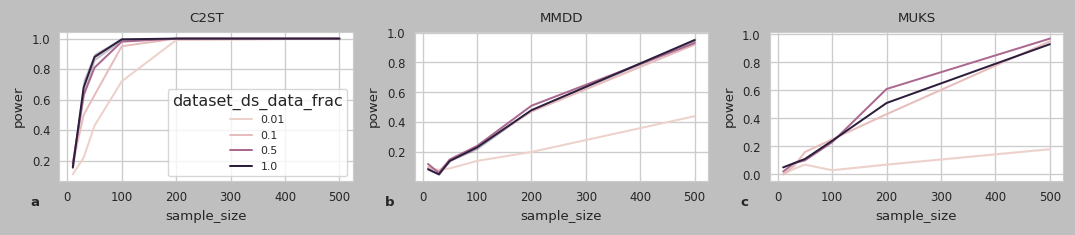

In [371]:

set_rcParams()

fig, ax = plt.subplots(1,3, figsize=(9,2))

idx=0
sns.lineplot(data=c2st, x='sample_size', y='power', hue='dataset_ds_data_frac', ax=ax[0])
ax[idx].set_title("C2ST")

txtkwargs = dict(size=8, weight='bold', va='top', ha='left')
# ax[idx].set(xscale="log")

idx=1
sns.lineplot(ax=ax[idx], data=mmdd, x='sample_size', y='power', hue='dataset_ds_data_frac')
ax[idx].set_title("MMDD")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")

idx=2
sns.lineplot(ax=ax[idx], data=muks, x='sample_size', y='power', hue='dataset_ds_data_frac')
ax[idx].set_title("MUKS")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")


for idx in range(3):
    ax[idx].text(-0.1, -0.1, string.ascii_lowercase[idx], transform=ax[idx].transAxes, **txtkwargs)

plt.tight_layout()




# Influence of Image Size on C2ST

In [377]:
df = pd.read_csv('all_results.csv')

df = df[df["dataset_ds_p_dataset"] == "eyepacs"]


df = df[df['path'].str.contains("task") == False]
df = df[df['path'].str.contains("eyepacs_quality_data_frac") == False]
df = df[df['path'].str.contains("eyepacs_quality_mmd_ablation") == False]

df = df[df['method'] != "muks"]

# x = df[df["dataset_ds_data_frac"]==1]

# x = df.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
# x["dataset_ds_q_subset_params_session_image_quality"]
x = df

quality = x.dropna(subset=["dataset_ds_q_subset_params_session_image_quality"])
ethnicity = x.dropna(subset=["dataset_ds_p_subset_params_patient_ethnicity"])
sex = x.dropna(subset=["dataset_ds_p_subset_params_patient_gender"])
comorbids = x.dropna(subset=["dataset_ds_q_subset_params_diagnoses_comorbidities"])

# c2st = x[x["method"] == "c2st" & x["dataset_ds_basic_preproc_img_size"] == 512]
c2st = x[x["method"] == "c2st"]
c2st = c2st[c2st["dataset_ds_basic_preproc_img_size"] == 512]
mmdd = x[x["method"] == "mmdd"] 
muks = x[x["method"] == "muks"] 


In [378]:
print(quality.shape)
print(ethnicity.shape)
print(sex.shape)
print(comorbids.shape)


(18, 38)
(126, 38)
(18, 38)
(18, 38)


/tmp/ipykernel_1233934/993644952.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality['attribute'] = "Quality"
/tmp/ipykernel_1233934/993644952.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comorbids['attribute'] = "Co-morbidities"
/tmp/ipykernel_1233934/993644952.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,method,attribute,sample_size,power,dataset_ds_basic_preproc_img_size
306,c2st,Quality,10,0.19,96
307,c2st,Quality,30,0.54,96
308,c2st,Quality,50,0.78,96
309,c2st,Quality,100,0.99,96
310,c2st,Quality,200,1.00,96
...,...,...,...,...,...
295,mmdd,Sex,30,0.07,96
296,mmdd,Sex,50,0.04,96
297,mmdd,Sex,100,0.06,96
298,mmdd,Sex,200,0.12,96


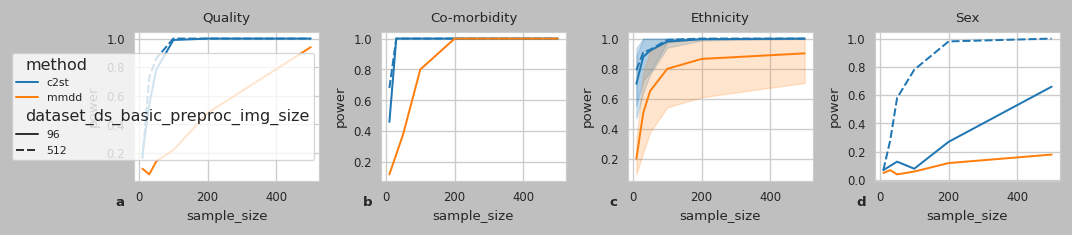

In [382]:

set_rcParams()

fig, ax = plt.subplots(1,4, figsize=(9,2))

idx=0
sns.lineplot(data=quality, x='sample_size', y='power', hue='method', ax=ax[0], style="dataset_ds_basic_preproc_img_size")
ax[idx].set_title("Quality")

txtkwargs = dict(size=8, weight='bold', va='top', ha='left')
# ax[idx].set(xscale="log")

idx=1
sns.lineplot(ax=ax[idx], data=comorbids, x='sample_size', y='power', hue='method', style="dataset_ds_basic_preproc_img_size")
ax[idx].set_title("Co-morbidity")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")

idx=2
sns.lineplot(ax=ax[idx], data=ethnicity, x='sample_size', y='power', hue='method', style="dataset_ds_basic_preproc_img_size")
ax[idx].set_title("Ethnicity")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")

idx=3
sns.lineplot(ax=ax[idx], data=sex, x='sample_size', y='power', hue='method', style="dataset_ds_basic_preproc_img_size")
ax[idx].set_title("Sex")
ax[idx].get_legend().remove()
# ax[idx].set(xscale="log")


for idx in range(4):
    ax[idx].text(-0.1, -0.1, string.ascii_lowercase[idx], transform=ax[idx].transAxes, **txtkwargs)

plt.tight_layout()

quality['attribute'] = "Quality"
comorbids['attribute'] = "Co-morbidities"
ethnicity['attribute'] = "Ethnicity"
sex['attribute'] = "Sex"



In [412]:


table_results = pd.concat([quality, comorbids, ethnicity, sex])
table_results = table_results[['method', 'attribute', 'sample_size', 'power', 'dataset_ds_basic_preproc_img_size']]

table_results
table_results = table_results.groupby(["sample_size", "method", "dataset_ds_basic_preproc_img_size", "attribute"])['power'].mean().reset_index()


table_rows = []

title_row_1 = "Shift & Test & 10 & 30 & 50 & 100 & 200 & 500 \n"
table_rows.append(title_row_1)

table_rows.append("\hline \n")

for shift_type in table_results['attribute'].unique():
    print(shift_type)

    c2st512 = table_results[(table_results['attribute'] == shift_type) & (table_results['dataset_ds_basic_preproc_img_size'] == 512)]
    c2st96 = table_results[(table_results['attribute'] == shift_type) & (table_results['dataset_ds_basic_preproc_img_size'] == 96)  & (table_results['method'] == "c2st")]
    mmdd = table_results[(table_results['attribute'] == shift_type) & (table_results['method'] == "mmdd")]

    row = f"{shift_type} & C2ST-512 & " + ' & '.join([f"{ele:.02f}" for ele in list(c2st512['power'])]) + "\\\\  \n"
    table_rows.append(row)

    row = f"{shift_type} & C2ST-96 & " + ' & '.join([f"{ele:.02f}" for ele in list(c2st96['power'])]) + "\\\\  \n"
    table_rows.append(row)

    row = f"{shift_type} & MMDD-96 & " + ' & '.join([f"{ele:.02f}" for ele in list(mmdd['power'])]) + "\\\\  \n"
    table_rows.append(row)

    table_rows.append("\hline \n")


table_file = "size_ablation_table.txt"
with open(table_file, "w") as f:
    f.writelines(table_rows)


Co-morbidities
['0.68', '1.00', '1.00', '1.00', '1.00', '1.00']
['0.46', '1.00', '1.00', '1.00', '1.00', '1.00']
['0.12', '0.25', '0.38', '0.80', '1.00', '1.00']
Co-morbidities & C2ST-512 & 0.68 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00\\  

Co-morbidities & C2ST-96 & 0.46 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00\\  

Co-morbidities & MMDD-96 & 0.12 & 0.25 & 0.38 & 0.80 & 1.00 & 1.00\\  

Ethnicity
['0.79', '0.91', '0.93', '0.99', '1.00', '1.00']
['0.70', '0.88', '0.92', '0.98', '1.00', '1.00']
['0.20', '0.50', '0.65', '0.80', '0.86', '0.90']
Ethnicity & C2ST-512 & 0.79 & 0.91 & 0.93 & 0.99 & 1.00 & 1.00\\  

Ethnicity & C2ST-96 & 0.70 & 0.88 & 0.92 & 0.98 & 1.00 & 1.00\\  

Ethnicity & MMDD-96 & 0.20 & 0.50 & 0.65 & 0.80 & 0.86 & 0.90\\  

Quality
['0.16', '0.73', '0.86', '1.00', '1.00', '1.00']
['0.19', '0.54', '0.78', '0.99', '1.00', '1.00']
['0.09', '0.05', '0.14', '0.22', '0.48', '0.94']
Quality & C2ST-512 & 0.16 & 0.73 & 0.86 & 1.00 & 1.00 & 1.00\\  

Quality & C2ST-96 & 0.19 & 0.54 & 0.78 & 

# MMD ablation

- Data augmentation yes/no
- Architecture backbon Liu (original) / Resnet50

/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/home/lkoch/miniconda3/envs/rebuttal/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Text(0.5, 1.0, 'MMD ablation')

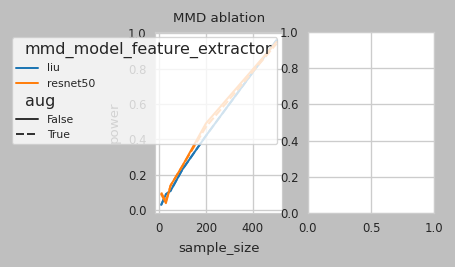

In [222]:
# exclude: mmd ablation experiments
mmdd = mmdd[mmdd['path'].str.contains("mmd_ablation")]

mmdd.shape

df = df[df["dataset_ds_p_dataset"] == "eyepacs"]

x = df[df['path'].str.contains("mmd_ablation")]

x.shape

# x['aug'] = x["dataset_ds_data_augmentation"].apply(len) > 0
x.loc[x.index.tolist(), 'aug'] = x["dataset_ds_data_augmentation"].apply(len) > 0
# x['aug'] = x['aug'] * 1

# # 'dataset_ds_data_augmentation', 'mmd_model_feature_extractor',

set_rcParams()

fig, ax = plt.subplots(1,2, figsize=(3,2))

idx=0
sns.lineplot(data=x, x='sample_size', y='power', hue='mmd_model_feature_extractor', ax=ax[0], style="aug")
ax[idx].set_title("MMD ablation")

# txtkwargs = dict(size=8, weight='bold', va='top', ha='left')
# ax[idx].set(xscale="log")

 




In [223]:
# y = x["dataset_ds_data_augmentation"].iloc[0]

# x['aug'] = x["dataset_ds_data_augmentation"].apply(len) > 0
# x['aug'] = x["dataset_ds_data_augmentation"].apply(lambda row: row.len > 0, axis=1)
# x["dataset_ds_data_augmentation"].apply(len) > 0


x[['power', 'aug', 'mmd_model_feature_extractor']]
# len(y)


power    aug  \
exp_hash                         sample_size                 
72046db431aa631aa2e65d31b58cd269 10            0.03   True   
                                 30            0.09   True   
                                 50            0.11   True   
                                 100           0.23   True   
                                 200           0.42   True   
                                 500           0.96   True   
790524599b4484f4000d80befe4c5853 10            0.10   True   
                                 30            0.05   True   
                                 50            0.14   True   
                                 100           0.25   True   
                                 200           0.47   True   
                                 500           0.94   True   
803f18a148590c2d925eb90a784ff259 10            0.03  False   
                                 30            0.09  False   
                                 50            0.11  False   
                                 100           0.23  False   
                                 200           0.42  False   
                                 500           0.96  False   
c8ebfac3829cf454cd2c84d50a011199 10            0.09  False   
                                 30            0.04  False   
                                 50            0.14  False   
                                 100           0.25  False   
                                 200           0.49  False   
                                 500           0.95  False   

                                             mmd_model_feature_extractor  
exp_hash                         sample_size                              
72046db431aa631aa2e65d31b58cd269 10                                  liu  
                                 30                                  liu  
                                 50                                  liu  
                                 100                                 liu  
                                 200                                 liu  
                                 500                                 liu  
790524599b4484f4000d80befe4c5853 10                             resnet50  
                                 30                             resnet50  
                                 50                             resnet50  
                                 100                            resnet50  
                                 200                            resnet50  
                                 500                            resnet50  
803f18a148590c2d925eb90a784ff259 10                                  liu  
                                 30                                  liu  
                                 50                                  liu  
                                 100                                 liu  
                                 200                                 liu  
                                 500                                 liu  
c8ebfac3829cf454cd2c84d50a011199 10                             resnet50  
                                 30                             resnet50  
                                 50                             resnet50  
                                 100                            resnet50  
                                 200                            resnet50  
                                 500                            resnet50

# T-SNE



In [ ]:
filename = "/home/lkoch/mnt/slurm_work/exp_lightning/eyepacs/eyepacs_comorb/c2st/566e8d7f1fda3c49425238833f60aaae/version_0/test_feat.npy"


